In [63]:
%%bash

pip3 install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [64]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import seaborn as sns

import itertools


df = pd.read_csv('/content/international-airline-passengers.csv',index_col=False,skiprows=0)
# print(df.iloc[0])

#      Month  International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
# 0                                              1949-01                                              112.0                             
# 1                                              1949-02                                              118.0   

# 데이터 확인
# print(df.info())
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 145 entries, 0 to 144
# Data columns (total 2 columns):
# Month                                                                             145 non-null object
# International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60    144 non-null float64
# dtypes: float64(1), object(1)
# memory usage: 2.3+ KB


# 컬럼명 변경
# print(df.columns)
# Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')
df.rename(columns={'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60':'passengers'},inplace=True)
df.rename(columns={'Month':'month'},inplace=True)

# 결측값 제거
df.dropna(axis=0, inplace=True)

# 날짜형 데이터로 변환
df['month'] = pd.to_datetime(df['month'])
# 날짜 데이터 인덱스 설정
df.set_index('month',inplace=True)

# 데이터 흐름 시각화
# plt.plot(df.index,df['passengers'])
# plt.show()

data = df



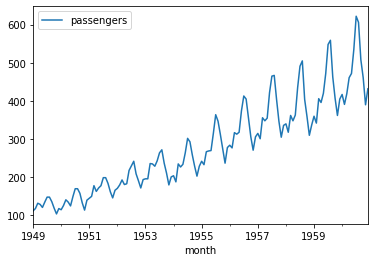

In [37]:
# 시각화
fig = data.plot()


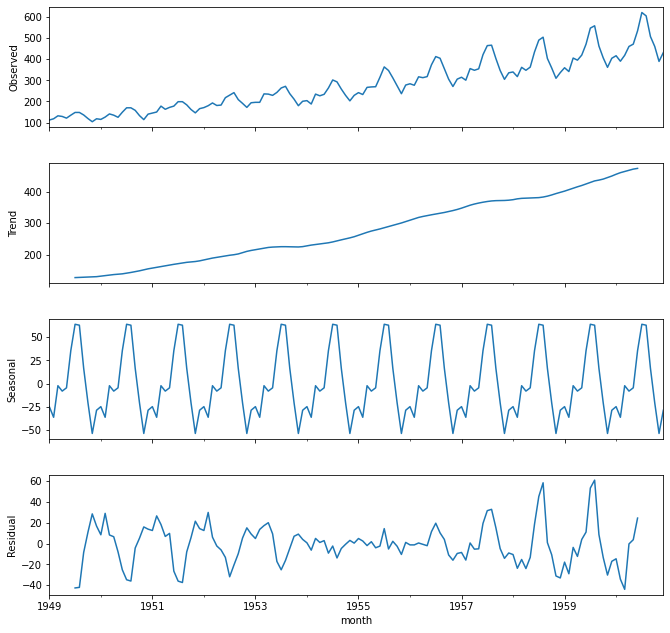

In [38]:
# Seasonal decomposition plot : Seasonal decomposition using moving averages.

# Observed : observed data 관측 데이터
# Trend : The estimated trend component 추세
# Seasonal : The estimated seasonal component 계절적
# resid : The estimated residuals 잔차


# 시즈널 디컴퍼즈 나눔 
decomposition = sm.tsa.seasonal_decompose(data['passengers'], model='additive') # period=1 옵션은 실행이 안되서 제외
# decomposition = sm.tsa.seasonal_decompose(data['passengers'], model='additive', period=1) 
fig = decomposition.plot() #
fig.set_size_inches(10,10) #크기 지정
plt.show()



In [39]:
## 트레인 데이터, 테스트 데이터 분리

train_data,test_data = train_test_split(data,test_size=0.2,shuffle=False) 
#shuffle을 False로 두면 랜덤하게 섞이지 않는다/시계열이므로 


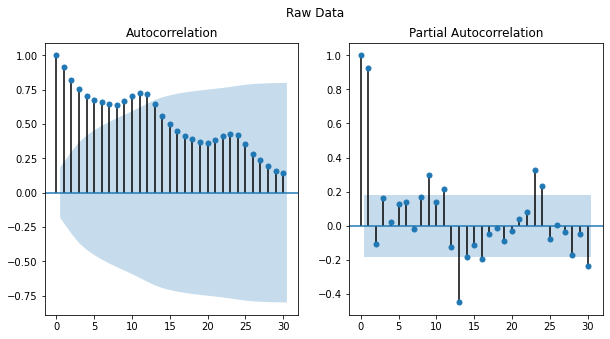

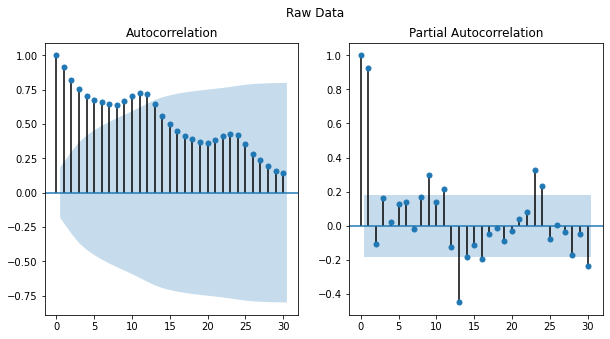

In [41]:
# ACF, PACF plot

# auto correlation function
# partial auto correlation function

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])


# ACF non-stationary 한 데이터임을 확인
# lag가 0일때는 무조건 1
# 천천히 떨어지면 non-stationary 대표
# stationary의 경우 lag기준 빠르게 떨어지던지, 패턴이 없음



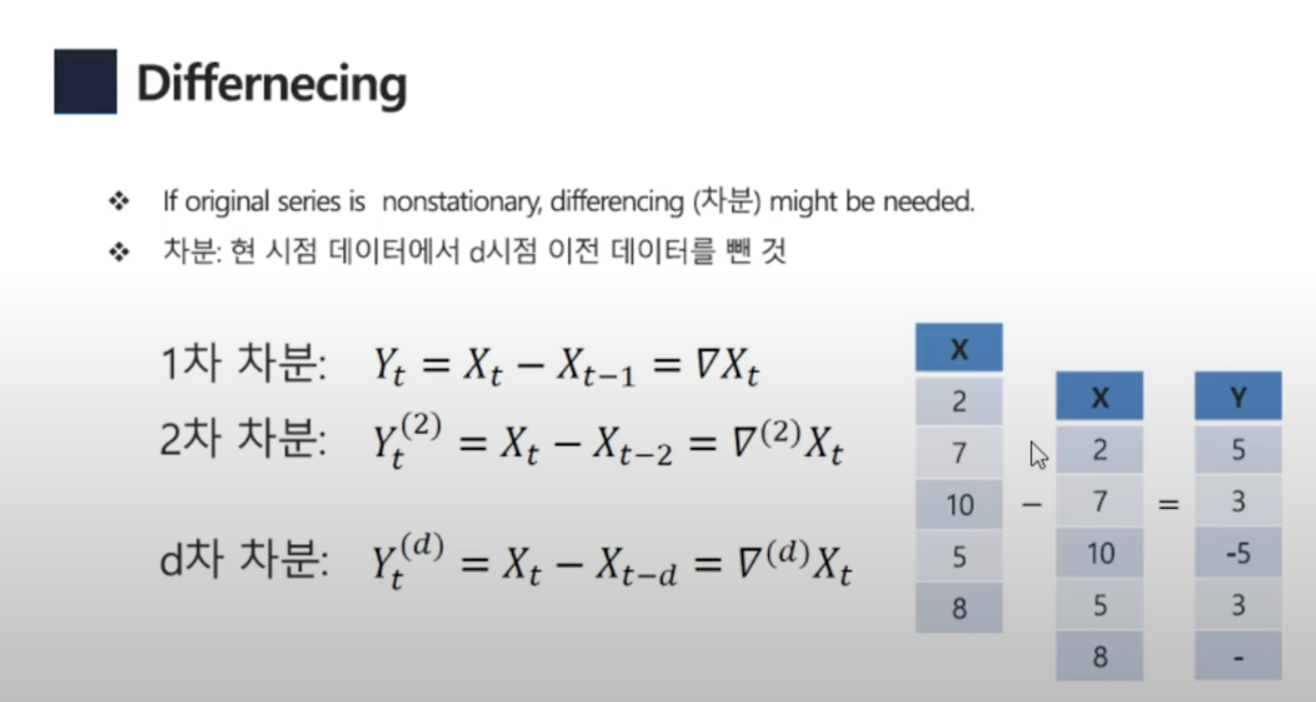

In [42]:
# stationary 하게 데이터를 보정
# 차분

diff_train_data = train_data.copy() #차분을 진행할 데이터 셋
diff_train_data = diff_train_data['passengers'].diff() #차분 진행
diff_train_data = diff_train_data.dropna() # 차분 진행이후 맨 마지막 열은 null이 되므로 제외


print(train_data)
print(diff_train_data)


            passengers
month                 
1949-01-01       112.0
1949-02-01       118.0
1949-03-01       132.0
1949-04-01       129.0
1949-05-01       121.0
...                ...
1958-03-01       362.0
1958-04-01       348.0
1958-05-01       363.0
1958-06-01       435.0
1958-07-01       491.0

[115 rows x 1 columns]
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


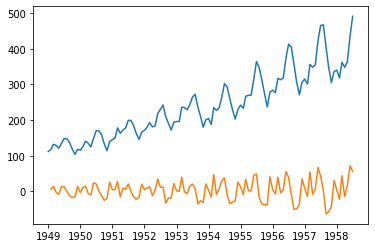

In [43]:
plt.plot(train_data)
plt.plot(diff_train_data)

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


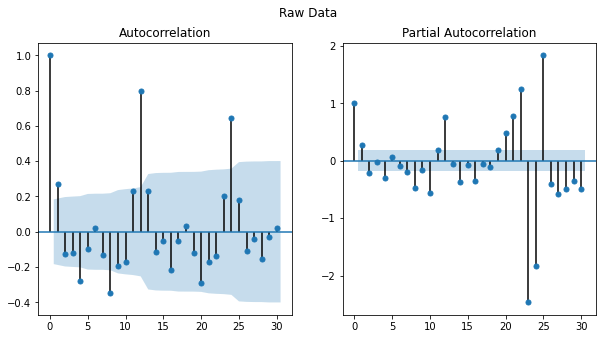

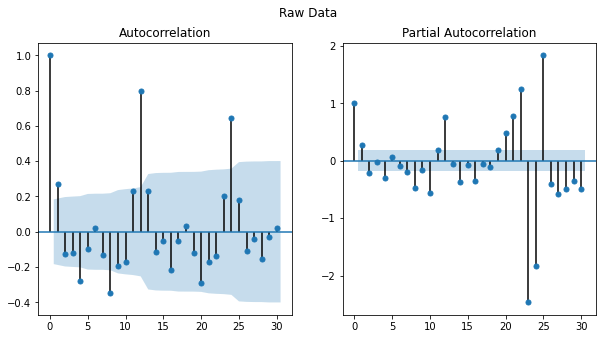

In [44]:
# 1차 차분된 데이터를 토대로 ACF, PACF plot

# auto correlation function
# partial auto correlation function

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])



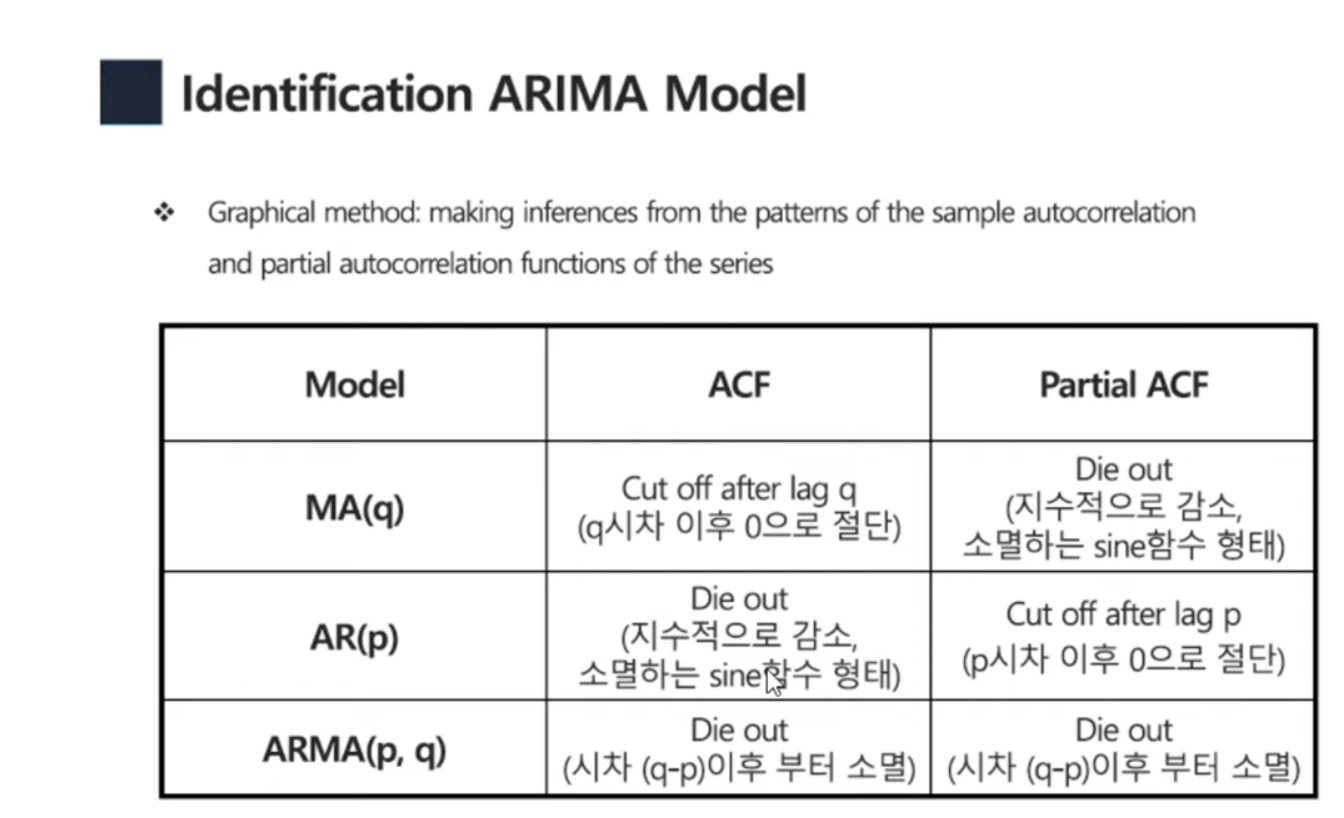

In [46]:
################################################ ARIMA 모델 도입
# the (p,d,q) order of the model for the mumber of AR parameters, differncesm and MA parameters to use.
# order 
# p : 
# d : 차분 1
# q : 

model = ARIMA(train_data.values, order=(1,1,0))
model_fit = model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -531.720
Method:                       css-mle   S.D. of innovations             25.659
Date:                Wed, 20 Jul 2022   AIC                           1069.440
Time:                        06:13:29   BIC                           1077.649
Sample:                             1   HQIC                          1072.771
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5123      3.329      1.055      0.294      -3.012      10.037
ar.L1.D.y      0.2803      0.091      3.077      0.003       0.102       0.459
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.5681           +0.0000j            3.5681            0.0000
-----------------------------------------------------------------------------
"""

In [56]:
import itertools
# parameter search

p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))

aic=[]

for i in pdq:
  model = ARIMA(train_data.values, order=(i))
  model_fit = model.fit()
  print(f'ARIMA : {i} >> AIC : {round(model_fit.aic,2)}')
  aic.append(round(model_fit.aic,2))

# ARIMA : (2, 1, 1) >> AIC : 1045.66 가장 낮은 스코어가 좋음


ARIMA : (0, 1, 0) >> AIC : 1076.52
ARIMA : (0, 1, 1) >> AIC : 1064.62
ARIMA : (0, 1, 2) >> AIC : 1061.08
ARIMA : (1, 1, 0) >> AIC : 1069.44
ARIMA : (1, 1, 1) >> AIC : 1058.83
ARIMA : (1, 1, 2) >> AIC : 1046.05
ARIMA : (2, 1, 0) >> AIC : 1066.2
ARIMA : (2, 1, 1) >> AIC : 1045.66
ARIMA : (2, 1, 2) >> AIC : 1047.19


In [57]:
################################################ ARIMA 모델 도입
# the (p,d,q) order of the model for the mumber of AR parameters, differncesm and MA parameters to use.
# order 
# p : 
# d : 차분 1
# q : 

model = ARIMA(train_data.values, order=(2,1,1))
model_fit = model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -517.830
Method:                       css-mle   S.D. of innovations             22.317
Date:                Wed, 20 Jul 2022   AIC                           1045.660
Time:                        06:33:20   BIC                           1059.341
Sample:                             1   HQIC                          1051.212
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5600      0.162     15.754      0.000       2.241       2.878
ar.L1.D.y      1.0890      0.085     12.816      0.000       0.922       1.256
ar.L2.D.y     -0.4730      0.086     -5.528      0.000      -0.641      -0.305
ma.L1.D.y     -0.9999      0.040    -25.219      0.000      -1.078      -0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1512           -0.8882j            1.4540           -0.1046
AR.2            1.1512           +0.8882j            1.4540            0.1046
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [67]:
auto_arima_model = auto_arima(train_data, start_p=1, start_q=1,
                              max_p=3, max_q=3, m=12, seasonal=True,
                              d=1,D=1,
                              max_P=3,max_Q=3,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=False
)

#파라미터를 지정해두면 자동으로 찾아주는 프로그램 pmdarima install
# start_p : p값의 최소값 (1,3)
# start_q : q값의 최소값 (1,3)
# max_p : p값의 최대값 (1,3)
# max_q : q값의 최대값 (1,3)
# m : 계절성을 의미, 월별 계절성이면 12, 분기별인 경우는 4
# 나머지는 정의 안해줘도 가능

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.33 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=758.826, Time=1.66 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.26 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.57 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=4.59 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=758.869, Time=0.56 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=760.726, Time=2.33 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=6.94 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=759.643, Time=1.63 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=10.52 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=756.688, Time=12.38 sec
 ARIMA(0,1,1)(0,1,0)[12]           

In [68]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(0, 1, 3)x(0, 1, 0, 12)   Log Likelihood                -372.468
Date:                            Wed, 20 Jul 2022   AIC                            752.936
Time:                                    07:04:31   BIC                            763.436
Sample:                                         0   HQIC                           757.188
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2214      0.095     -2.330      0.020      -0.408      -0.035
ma.L2          0.1246      0.109      1.146      0.252      -0.088       0.338
ma.L3         -0.2929      0.103     -2.836      0.005      -0.495      -0.090
sigma2        86.6902     13.294      6.521      0.000      60.635     112.746
===================================================================================
Ljung-Box (Q):                       33.71   Jarque-Bera (JB):                 2.79
Prob(Q):                              0.75   Prob(JB):                         0.25
Heteroskedasticity (H):               1.12   Skew:                             0.37
Prob(H) (two-sided):                  0.75   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
# 예측

prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data,predicted_value)

In [84]:
print(prediction[0]) # 실제 예측값
print(test_data) # 실제 값 

# print(prediction[1][:,0]) # 예측 최소값
# print(prediction[1][:,1]) # 예측 최대값

print(r2) #0.738782260212149 

[489.8565956  427.21118196 367.24184791 325.24184791 356.24184791
 360.24184791 338.24184791 382.24184791 368.24184791 383.24184791
 455.24184791 511.24184791 510.09844351 447.45302987 387.48369582
 345.48369582 376.48369582 380.48369582 358.48369582 402.48369582
 388.48369582 403.48369582 475.48369582 531.48369582 530.34029143
 467.69487778 407.72554373 365.72554373 396.72554373]
            passengers
month                 
1958-08-01       505.0
1958-09-01       404.0
1958-10-01       359.0
1958-11-01       310.0
1958-12-01       337.0
1959-01-01       360.0
1959-02-01       342.0
1959-03-01       406.0
1959-04-01       396.0
1959-05-01       420.0
1959-06-01       472.0
1959-07-01       548.0
1959-08-01       559.0
1959-09-01       463.0
1959-10-01       407.0
1959-11-01       362.0
1959-12-01       405.0
1960-01-01       417.0
1960-02-01       391.0
1960-03-01       419.0
1960-04-01       461.0
1960-05-01       472.0
1960-06-01       535.0
1960-07-01       622.0
1960-08-01       6

Text(0.5, 0.98, 'SARIMA (0, 1, 3),(0, 1, 0, 12) Prediction Results (r2 Score : 0.74)')

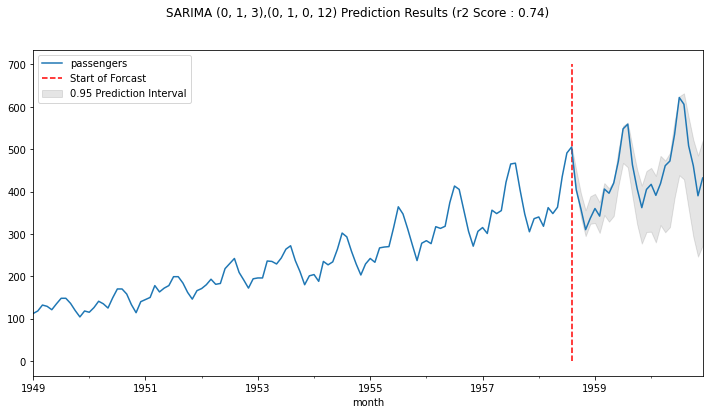

In [72]:
fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax)
ax.vlines('1958-08-01',0,700, linestyle='--',color='r',label='Start of Forcast')
ax.fill_between(predict_index,predicted_lb,predicted_ub, color='k',alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order},{auto_arima_model.seasonal_order} Prediction Results (r2 Score : {round(r2,2)})')

실제 데이터와 최근 5달의 값을 비교